# Capstone Project 1 - Inferential Statistics

In this notebook, I will use inferential statistics to answer several questions about the credit card client default data set.

The questions that I will try to answer are as follows:
1. Is the proportion of defaults the same for men and women?
2. Is age a significant predictor of default?
3. Is credit limit a significant predictor of default?
4. Is the ratio of $\left(\frac{\text{bill amount}}{\text{credit limit}}\right)$ a significant predictor of default? Here, "$\text{bill amount}$" stands for past credit card bill amounts.
5. Is the ratio of $\left(\frac{\text{bill amount} - \text{pay amount}}{\text{credit limit}}\right)$ a significant predictor of default? 

In the process of answering question 6 and 7, we found it necessary to engineer some additional features.  At the end of this notebook, we will run a function that we have defined to create a new `.csv` file that contains our wrangled data along with the new features we engineer.


In [1]:
# Import libraries
import os
import sys
import inspect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Modify notebook settings
%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.max_columns = 100

### Create paths to data file, append `src` directory to sys.path

In [2]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save path to the wrangled data file
# "dataset_wrangled.csv"
wrangled_data_file = os.path.join(proj_root,
                                "data",
                                "interim",
                                "dataset_wrangled.csv")

In [3]:
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(proj_root, "src")
sys.path.append(src_dir)

### Read in wrangled data

In [4]:
# Read in the wrangled credit card client default data set.

df_wrangled = pd.read_csv(wrangled_data_file,
                          header=1, 
                          index_col=0)
#df_wrangled.head()

### Significance level ($\alpha$)

In all of the hypothesis tests in this notebook, we will use a significance level of $\alpha = 0.05$.

In [5]:
# Set alpha
alpha = 0.05

In [6]:
# Set upper bound and lower bound of percentiles
# for calculating confidence intervals, given alpha.
lb = (alpha/2)
ub = 1 - (alpha/2)
bounds = [lb, ub]

### 1. Is the proportion of defaults the same for men and women?

We want to test whether the proportion of defaults the same for men and women.

Let $p_m$ represent the proportion of defaults for men.

Let $p_w$ represent the proportion of defaults for women.

Our null and alternative hypotheses are as follows:

+ $H_0$: $p_m = p_w$

+ $H_1$: $p_m \neq p_w$



In [7]:
# Create a function to calculate the proportion of defaults by sex.
def make_proportion_dict(df):
    """
    Given a DataFrame, return a dictionary where sex labels
    ('Male' and 'Female') are the keys and the proportion of 
    defaults are the values.
    """
    output_dict = {'Male': df[df['SEX'] == 1]['default payment next month'].value_counts(normalize=True).loc[1],
                   'Female': df[df['SEX'] == 2] ['default payment next month'].value_counts(normalize=True).loc[1]}
    return output_dict

In [8]:
make_proportion_dict(df_wrangled)

{'Female': 0.20776280918727916, 'Male': 0.24167227456258411}

In [9]:
def resample(df, iters=1000):
    list_m = []
    list_w = []
    n = len(df)
    for i in range(iters):
        resampled_df = df[['default payment next month', 
                           'SEX']].sample(n=n, replace=True)
        proportions = make_proportion_dict(resampled_df)
        list_m.append(proportions['Male'])
        list_w.append(proportions['Female'])
    prop_array_m = np.array(list_m)
    prop_array_w = np.array(list_w)
    return prop_array_m, prop_array_w 

In [10]:
results_m, results_w = resample(df_wrangled, iters=1000)

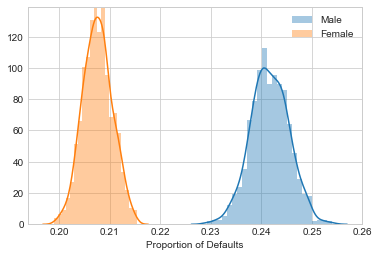

In [11]:
sns.distplot(results_m,
             norm_hist=True, 
             label='Male')
sns.distplot(results_w,
             norm_hist=True, 
             label='Female')

plt.xlabel('Proportion of Defaults')
plt.legend()

We reject the null hypothesis that $p_m = p_w$

### 2. Is age a significant predictor of default?

We conduct a logistic regression where age is the predictor variable and default status is the target variable.

We use the implementation of logistic regression in the `glm` package in the R language.  We chose to use `glm`'s implementation because it calculates the p-values associated with each regression coefficient. The logistic regression implemented in `scikit-learn` does not calculate these p-values. 

We use the `rpy2` Python library to call R from within Python.

In [12]:
# Import modules
from rpy2.robjects import FloatVector, Formula
from rpy2.robjects.packages import importr
# import glm from the source code
import models.glm as glm

In [13]:
# Create robjects for X ('AGE'), 
# y ('default payment next month'), 
# regression formula, and the environment
y = df_wrangled['default payment next month']
X = df_wrangled['AGE']

y_r = FloatVector(y)
X_r = FloatVector(X)

fmla = Formula('y_r ~ X_r')
env = fmla.environment

env['y_r'] = y_r
env['X_r'] = X_r

In [14]:
glm_result = glm.logit_model(model='y_r ~ X_r')

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.386982   0.055242 -25.107   <2e-16 ***
X_r          0.003607   0.001499   2.406   0.0162 *  
---

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 31705  on 29999  degrees of freedom
Residual deviance: 31700  on 29998  degrees of freedom
AIC: 31704

Number of Fisher Scoring iterations: 4




In [15]:
p_val = 0.0162

In [16]:
p_val < alpha

True

From these results, we see that the p-value for the regression coefficient of X_r  is 0.0162, which is less than $\alpha = 0.05$.  Therefore, we conclude that age is a statistically significant predictor of default.

The regression coefficient is positive, implying that the log-odds of default increase as age increases.

### 3. Is credit limit a significant predictor of default?

We conduct a logistic regression where credit limit is the predictor variable and default status is the target variable.

In [17]:
# Create robjects for X ('LIMIT_BAL'), 
# y ('default payment next month'), 
# regression formula, and the environment
y = df_wrangled['default payment next month']
X = df_wrangled['LIMIT_BAL']

y_r = FloatVector(y)
X_r = FloatVector(X)

fmla = Formula('y_r ~ X_r')
env = fmla.environment

env['y_r'] = y_r
env['X_r'] = X_r

In [18]:
glm_result = glm.logit_model(model='y_r ~ X_r')

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.556e-01  2.241e-02  -33.71   <2e-16 ***
X_r         -3.302e-06  1.263e-07  -26.14   <2e-16 ***
---

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 31705  on 29999  degrees of freedom
Residual deviance: 30931  on 29998  degrees of freedom
AIC: 30935

Number of Fisher Scoring iterations: 4




From these results, we see that the p-value for the regression coefficient of X_r  is less than $2 \times 10^{-16}$, which is less than $\alpha = 0.05$.  Therefore, we conclude that credit limit is a statistically significant predictor of default.  

The regression coefficient is negative, implying that the log-odds of default decrease as credit limit increases.

### 4. Is the ratio of $\left(\frac{\text{bill amount}}{\text{credit limit}}\right)$ a significant predictor of default? 

Here, "$\text{bill amount}$" stands for past credit card bill amounts.

We conduct a logistic regression where the ratio of $\left(\frac{\text{bill amount}}{\text{credit limit}}\right)$ is the predictor variable and default status is the target variable.

In [19]:
def build_features_ba_over_cl(df):

    bill_amount_column_list = ['BILL_AMT1',
                               'BILL_AMT2',
                               'BILL_AMT3',
                               'BILL_AMT4',
                               'BILL_AMT5',
                               'BILL_AMT6']

    df_new = df.copy()
    
    for i, ba in enumerate(bill_amount_column_list, 1):

        new_column_name = 'ba_over_cl_' + str(i)
        
        df_new[new_column_name] = \
            df_wrangled[ba] / df_wrangled['LIMIT_BAL']

    return df_new

In [20]:
new_df = build_features_ba_over_cl(df_wrangled)
# new_df.head()

In [21]:
ba_over_cl_list = ['ba_over_cl_1', 
                   'ba_over_cl_2',
                   'ba_over_cl_3', 
                   'ba_over_cl_4', 
                   'ba_over_cl_5', 
                   'ba_over_cl_6']
    
for col in ba_over_cl_list:
    print('\n')
    print('X_r:', col)
    print('\n')
    
    y = new_df['default payment next month']
    X = new_df[col]

    y_r = FloatVector(y)
    X_r = FloatVector(X)

    fmla = Formula('y_r ~ X_r')
    env = fmla.environment

    env['y_r'] = y_r
    env['X_r'] = X_r
    glm_result = glm.logit_model(model='y_r ~ X_r')
    
#    print(glm_result)



X_r: ba_over_cl_1


Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.47738    0.02088  -70.75   <2e-16 ***
X_r          0.48985    0.03315   14.78   <2e-16 ***
---

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 31705  on 29999  degrees of freedom
Residual deviance: 31488  on 29998  degrees of freedom
AIC: 31492

Number of Fisher Scoring iterations: 4




X_r: ba_over_cl_2


Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.50855    0.02093  -72.07   <2e-16 ***
X_r          0.57228    0.03378   16.94   <2e-16 ***
---

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 31705  on 29999  degrees of freedom
Residual deviance: 31418  on 29998  degrees of freedom
AIC: 31422

Number of Fisher Scoring iterations: 4




X_r: ba_over_cl_3


Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.51592    0.02078  -72.95   <2e-16 ***
X_r          0.6

From these results, we see that the p-value for the regression coefficient of each X_r  is less than $2 \times 10^{-16}$, which is less than $\alpha = 0.05$.  Therefore, we conclude that, for each of the 6 bill amounts, the ratio of $\left(\frac{\text{bill amount}}{\text{credit limit}}\right)$ is a statistically significant predictor of default.  

The regression coefficients are positive, implying that the log-odds of default increase as the ratio of $\left(\frac{\text{bill amount}}{\text{credit limit}}\right)$ increases.

### 5. Is the ratio of $\left(\frac{\text{bill amount} - \text{pay amount}}{\text{credit limit}}\right)$ a significant predictor of default? 

We conduct a logistic regression where the ratio of $\left(\frac{\text{bill amount} - \text{pay amount}}{\text{credit limit}}\right)$ is the predictor variable and default status is the target variable.


In [22]:
def build_features_ba_less_pa_over_cl(df):

    bill_amount_column_list = ['BILL_AMT1',
                               'BILL_AMT2',
                               'BILL_AMT3',
                               'BILL_AMT4',
                               'BILL_AMT5',
                               'BILL_AMT6']

    pay_amount_column_list = ['PAY_AMT1',
                              'PAY_AMT2',
                              'PAY_AMT3',
                              'PAY_AMT4',
                              'PAY_AMT5',
                              'PAY_AMT6']

    df_new = df.copy()
    
    for i, (ba, pa) in enumerate(zip(bill_amount_column_list, 
                               pay_amount_column_list), 
                           1):

        new_column_name = 'ba_less_pa_over_cl_' + str(i)
        
        df_new[new_column_name] = \
            (df_wrangled[ba] -df_wrangled[pa])/ df_wrangled['LIMIT_BAL']

    return df_new

In [23]:
new_df = build_features_ba_less_pa_over_cl(new_df)
#new_df.head()

In [24]:
ba_less_pa_over_cl_list = ['ba_less_pa_over_cl_1', 
                           'ba_less_pa_over_cl_2',
                           'ba_less_pa_over_cl_3', 
                           'ba_less_pa_over_cl_4', 
                           'ba_less_pa_over_cl_5', 
                           'ba_less_pa_over_cl_6']
    
for col in ba_less_pa_over_cl_list:
    print('\n')
    print('X_r:', col)
    print('\n')
    
    y = new_df['default payment next month']
    X = new_df[col]

    y_r = FloatVector(y)
    X_r = FloatVector(X)

    fmla = Formula('y_r ~ X_r')
    env = fmla.environment

    env['y_r'] = y_r
    env['X_r'] = X_r
    glm_result = glm.logit_model(model='y_r ~ X_r')
    
#    print(glm_result)



X_r: ba_less_pa_over_cl_1


Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.46832    0.01990  -73.79   <2e-16 ***
X_r          0.52003    0.03321   15.66   <2e-16 ***
---

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 31705  on 29999  degrees of freedom
Residual deviance: 31459  on 29998  degrees of freedom
AIC: 31463

Number of Fisher Scoring iterations: 4




X_r: ba_less_pa_over_cl_2


Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.50342    0.02000  -75.16   <2e-16 ***
X_r          0.61929    0.03385   18.30   <2e-16 ***
---

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 31705  on 29999  degrees of freedom
Residual deviance: 31367  on 29998  degrees of freedom
AIC: 31371

Number of Fisher Scoring iterations: 4




X_r: ba_less_pa_over_cl_3


Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.49918    0.01988  -75.41   <2e

From these results, we see that the p-value for the regression coefficient of each X_r  is less than $2 \times 10^{-16}$, which is less than $\alpha = 0.05$.  Therefore, we conclude that, for each of the 6 (bill amount, pay amount) pairs, the ratio of $\left(\frac{\text{bill amount} - \text{pay amount}}{\text{credit limit}}\right)$ is a statistically significant predictor of default.  

The regression coefficients are positive, implying that the log-odds of default increase as the ratio of 
$\left(\frac{\text{bill amount} - \text{pay amount}}{\text{credit limit}}\right)$ increases.

## Feature Engineering

Next, we will engineer two sets of six features.  These sets consist of:
+ the ratio of $\left(\frac{\text{bill amount}}{\text{credit limit}}\right)$, and
+ the ratio of $\left(\frac{\text{bill amount} - \text{pay amount}}{\text{credit limit}}\right)$.

The new dataset that includes these new features will saved to a file called `dataset_interim.csv` in the `interim` folder.

In [25]:
# import build_features from the source code
import features.build_ratio_features as brf

In [26]:
# Engineer features
brf.create_interim_dataset(new_file_name='dataset_interim.csv')

Review the `dataset_interim.csv` file to check that the feature engineering worked as expected.

In [27]:
# Save path to the interim data file
# "dataset_interim.csv"
interim_data_file = os.path.join(proj_root,
                                   "data",
                                   "interim",
                                   "dataset_interim.csv")

# Read in the new credit card client default data set.
df_new = pd.read_csv(interim_data_file, 
                           index_col=0)

df_new.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,ba_over_cl_1,ba_over_cl_2,ba_over_cl_3,ba_over_cl_4,ba_over_cl_5,ba_over_cl_6,ba_less_pa_over_cl_1,ba_less_pa_over_cl_2,ba_less_pa_over_cl_3,ba_less_pa_over_cl_4,ba_less_pa_over_cl_5,ba_less_pa_over_cl_6
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.195650,0.155100,0.034450,0.000000,0.000000,0.000000,0.195650,0.120650,0.034450,0.000000,0.000000,0.000000
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.022350,0.014375,0.022350,0.027267,0.028792,0.027175,0.022350,0.006042,0.014017,0.018933,0.028792,0.010508
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0.324878,0.155856,0.150656,0.159233,0.166089,0.172767,0.308011,0.139189,0.139544,0.148122,0.154978,0.117211
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.939800,0.964660,0.985820,0.566280,0.579180,0.590940,0.899800,0.924280,0.961820,0.544280,0.557800,0.570940
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0.172340,0.113400,0.716700,0.418800,0.382920,0.382620,0.132340,-0.620220,0.516700,0.238800,0.369140,0.369040


The feature engineering worked as expected.